# Transformation of random variables

## Motivating example: Deformation of rod under tension
- Deformation $\Delta l = \frac{Nl}{EA}$
- Length of the rod $l$ is know.
- Normal force $N(x)=N$ and Young modulus $E(x)=E$ are both assumed constant along the rod's lengths. Their values are known and fixed.
- Area of cross section $A$ is assumed random and uniformly distributed within bounds $a_l$ (lower) and $a_u$ (upper), i.e. $A\sim\mathcal{U}(a_l,a_u)$
- Failure is defined as $\Delta l>\Delta l_{lim}$, where $\Delta l_{lim}$ is maximal allowed deformation (fixed, known).

**Summary**
- $l$, $N$, $E$, $a_l$, $a_u$ and $\Delta l_{lim}$ are known real numbers
- $A\sim\mathcal{U}(a_l,a_u)$ is continuous random variable

**Questions**
1. Calculate the reliability of the structure, i.e. $\Pr(\Delta l<\Delta l_{lim})$.
- Express the PDF of $\Delta l$.
- Find mean value of $\Delta l$, i.e. $\operatorname{E}[\Delta l]$.

Verify all results by simulation.


**Intuitive solution to question 1.:**

We find limit area $a_{lim}$ that would lead to the limit deformation $\Delta l_{lim}$.

$$a_{lim} = \frac{Nl}{E \Delta l_{lim}}$$

Reliability (probability of NOT failure) is 
$$\Pr(\Delta l<\Delta l_{lim}) = \Pr(A>a_{lim})$$

Variable $A$ is continuous, uniformly distributed. It's PDF is

$$
  f_A(a)=\begin{cases}
  \frac{1}{a_u - a_l} & \mathrm{for}\ a_l \le x \le a_u, \\
  0 & \mathrm{othervise}
  \end{cases}
$$

The probability of failure is

$$
P_f = \Pr(A<a_{lim})=F_A(a_{lim}) = \int_{-\infty}^{a_{lim}} f_A(a) da = \frac{1}{a_u-a_l}\int_{-\infty}^{a_{lim}} da = \frac{1}{a_u-a_l}(a_{lim} - a_l)
$$

In [2]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Known values
l = 5 # [m]
N = 100 # [kN]
E = 210e6 # [kPa]
a_l, a_u = 1.0e-4, 2.0e-4 # [m2]
delta_l_lim = 0.02 # [m]

# Limit cross-section area
a_lim = N * l / E / delta_l_lim

# Probability of failure 
pf_an = (a_lim - a_l) / (a_u - a_l)

print(f"a_lim = {a_lim}")
print(f"pf_an = {pf_an}")

a_lim = 0.00011904761904761903
pf_an = 0.19047619047619027


Now check that numerically. First, generate samples of random cross section area $A$...

In [5]:
# Get random samples of uniform distribution.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
a_samples = scipy.stats.uniform.rvs(size=1_000_000, loc = a_l, scale=a_u-a_l)

print(type(a_samples))
print(a_samples)

<class 'numpy.ndarray'>
[0.00016519 0.00011893 0.00017904 ... 0.00019386 0.0001638  0.00012271]


... and plot histogram of the data to check that we got what we wanted.

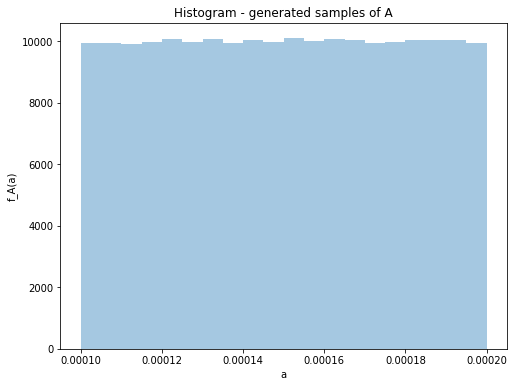

In [13]:
# Create plot 
fig, ax = plt.subplots(figsize=(8,6));

# Plot histogram with kernel density line
sns.distplot(a_samples, bins=20, norm_hist=True, kde=False) 

ax.set_title("Histogram - generated samples of A");
ax.set_xlabel("a");
ax.set_ylabel("f_A(a)");

Then we transform the samples of $A$ into samples of $\Delta l$.

In [14]:
delta_l_samples = N * l / E / a_samples

print(type(delta_l_samples))
print(delta_l_samples)

<class 'numpy.ndarray'>
[0.01441368 0.02001928 0.01329859 ... 0.01228212 0.01453612 0.01940351]


We count the "failed" samples, for which $\Delta l > \Delta l_{lim}$, and divide it by number of all samples to get probability of failure.

In [15]:
condition = delta_l_samples > delta_l_lim
num_fail = len(delta_l_samples[condition])
num_all = len(delta_l_samples)

pf_num = num_fail / num_all

print(f"condition = {condition}")
print(f"num_fail = {num_fail}")
print(f"num_all = {num_all}")
print(f"pf_num = {pf_num}")
print(f"Compare to pf_an = {pf_an}")

condition = [False  True False ... False False False]
num_fail = 189370
num_all = 1000000
pf_num = 0.18937
Compare to pf_an = 0.19047619047619027


In [16]:
from IPython.display import Markdown as md

md(f"**Answer:** Probability of failure is $P_f = {pf_an}$.")

**Answer:** Probability of failure is $P_f = 0.19047619047619027$.

**Solution to question 2. - Find PDF of $\Delta l$:**

Distributio of $A$ is uniform. What about the distribution of $\Delta l$?

**A bit of theory:** The tranformation rule is derived from equality of probabilities

$$ f_X(x) dx = f_Y(y) dy $$

and comes in form
$$f_Y(y) = \left| \frac{dx}{dy} \right| f_X(x)$$

In our case, the transformation function is
$$ \Delta l = \frac{N l}{E A}$$

The inverse transformation is
$$ A = \frac{N l}{E \Delta l}$$

By differentiation we get
$$\frac{dA}{d(\Delta l)} = -\frac{N l}{E (\Delta l)^2}$$

Now substituting into the transformation rule we get
$$ f_{\Delta l}(\Delta l) = \left| -\frac{N l}{E (\Delta l)^2} \right| f_A\left(\frac{N l}{E \Delta l}\right)$$


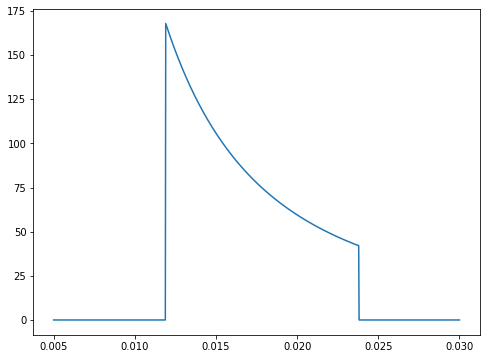

In [17]:
# PDF of A
def f_A(a):
    if a > a_l and a < a_u:
        return 1.0 / (a_u - a_l)
    else:
        return 0.0

# Jacobian of transformation    
def d_A_d_Delta_l(Delta_l):
    return -N * l / E / Delta_l**2.0

# PDF of Delta l
def f_Delta_l(Delta_l):
    return abs(d_A_d_Delta_l(Delta_l)) * f_A(N * l / E / Delta_l)
    
points = np.linspace(0.005, 1.5 * delta_l_lim, 1000)
values = np.array([f_Delta_l(p) for p in points])

# PLOT
fig, ax = plt.subplots(figsize=(8,6));

# Plot PDF 
plt.plot(points, values);

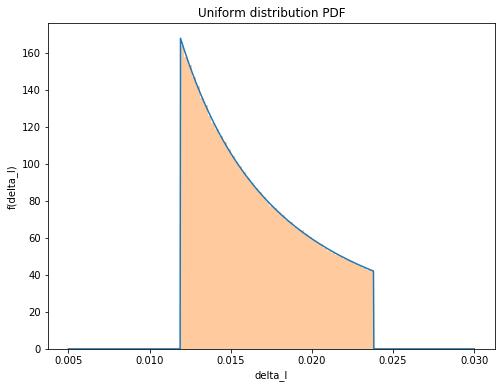

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot PDF 
plt.plot(points, values);

# Plot histogram with kernel density line
sns.distplot(delta_l_samples, bins=50, norm_hist=True, kde=False) 

ax.set_title("Uniform distribution PDF");
ax.set_xlabel("delta_l");
ax.set_ylabel("f(delta_l)");

**Solution to question 3. - Find mean value of the rod's deformation $\operatorname{E}[\Delta l]$**

Definition of mean value
$$\operatorname{E}[X] = \int_{-\infty}^{\infty}x f_{X}(x) dx$$

In our case
$$\operatorname{E}[\Delta l] = \int_{-\infty}^{\infty}\Delta l f_{\Delta l}(\Delta l) d(\Delta l)$$

Function $f_{\Delta l}()$ is zero outside its limits (Note that the upper and lower limits are switched because the transformation function is decreasing)

$$\Delta l_l = \frac{N l}{E a_u}$$
$$\Delta l_u = \frac{N l}{E a_l}$$

So it is sufficient to integrate only within these limits
\begin{align}
\operatorname{E}[\Delta l] &= \int_{\Delta l_l}^{\Delta l_u}\Delta l f_{\Delta l}(\Delta l) d(\Delta l)\\
&=\int_{\frac{N l}{E a_u}}^{\frac{N l}{E a_l}}\Delta l \frac{Nl}{E (\Delta l)^2}\frac{1}{a_u - a_l} d(\Delta l)\\
&=\frac{N l}{E(a_u-a_l)}\left[\ln(\Delta l)\right]_{\Delta l = \frac{N l}{E a_u}}^{\frac{N l}{E a_l}}\\
&=\frac{N l}{E(a_u-a_l)}\left[\ln\left(\frac{N l}{E a_l}\right) - \ln\left(\frac{N l}{E a_u}\right) \right]\\
&=\frac{N l}{E(a_u-a_l)}\ln\left(\frac{a_u}{a_l}\right)
\end{align}


In [19]:
print(f"Delta l_l = {N * l / E / a_u}")
print(f"Delta l_u = {N * l / E / a_l}")

Delta l_l = 0.011904761904761904
Delta l_u = 0.023809523809523808


In [20]:
import math
delta_l_mean = N * l / E / (a_u - a_l) * math.log(a_u / a_l)
print(f"Analytically: E[delta l] = {delta_l_mean}")

# Numerically: average value of delta l samples
print(f"Numerically: E[delta l] = {delta_l_samples.mean()}")

Analytically: E[delta l] = 0.016503504299046314
Numerically: E[delta l] = 0.016497151536482416
